In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold



In [107]:
X_train_1 = pd.read_csv("../data/boost/X_train_boost_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/boost/X_train_boost_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/boost/X_train_boost_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")
X_test =pd.read_csv("../data/boost/X_test_boost.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

# 1. CatBoost

## 1.1 Modelling

reference source:
https://www.datacamp.com/tutorial/catboost?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157156375191&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=720362650048&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9062544&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-bfcm24&gad_source=1&gbraid=0AAAAADQ9WsG32eomnlc7yr8qhNh_B0rIf&gclid=Cj0KCQiAouG5BhDBARIsAOc08RTtF6F_VSv0Hck1Glr8j0gGVjz_VMrRDLXIkIP5HY1nmm-GCR6qguUaAmvBEALw_wcB

In [108]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]


We set iterations at 300 and learning rate at 0.1, depth at 6, verbose initially and will adjust them later.

In [109]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train, cat_features=categorical_feature_indices)  

## 1.2 Evaluation

### 1.2.1 RMSE and R2 score

In [ ]:
# Make predictions on the train set
y_train_pred = model.predict(X_train)

# Calculate train performance metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2 Score: {train_r2}")

Train RMSE: 30189.43254688699
Train R2 Score: 0.969504429945646


In [ ]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate test performance metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 30647.69027868796
Test R2 Score: 0.9687033057355025


R2 Score seems to be high.  We supposed the model performed well because CatBoost can deal with categorical features with a large number of unique values. However, we would like to further check if the model is overfitting or underfitting and how to can further refine and tune the parameters.

### 1.2.2 Training Loss vs Validation Loss

We used the approach of validation to plot a graph of training loss and validation loss to check whether over fitting or underfitting occured.

source: https://www.baeldung.com/cs/training-validation-loss-deep-learning

In [ ]:

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


0:	learn: 159099.7771664	test: 159485.4336210	best: 159485.4336210 (0)	total: 141ms	remaining: 42.1s
100:	learn: 38259.6755813	test: 37159.6154999	best: 37159.6154999 (100)	total: 14.3s	remaining: 28.1s
200:	learn: 33827.6474552	test: 32585.6248893	best: 32585.6248893 (200)	total: 28.5s	remaining: 14s
299:	learn: 31530.7394108	test: 30284.5024752	best: 30284.5024752 (299)	total: 43.8s	remaining: 0us

bestTest = 30284.50248
bestIteration = 299



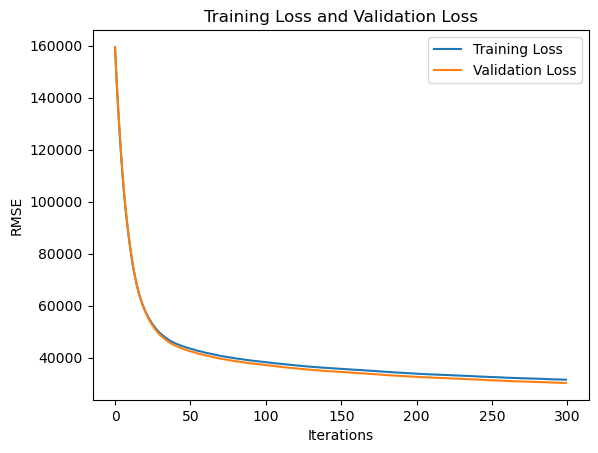

In [ ]:
model.fit(X_train, y_train, cat_features=categorical_feature_indices, eval_set=(X_val, y_val), verbose=100)

# Extract metrics
train_loss = model.get_evals_result()['learn']['RMSE']
val_loss = model.get_evals_result()['validation']['RMSE']

# Plot losses

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training Loss and Validation Loss')
plt.show()


According to the graph, both validation and training loss are decreasing, which shows the model is good fitting. 

### 1.2.3 Predicted vs Actual, Residual Plot

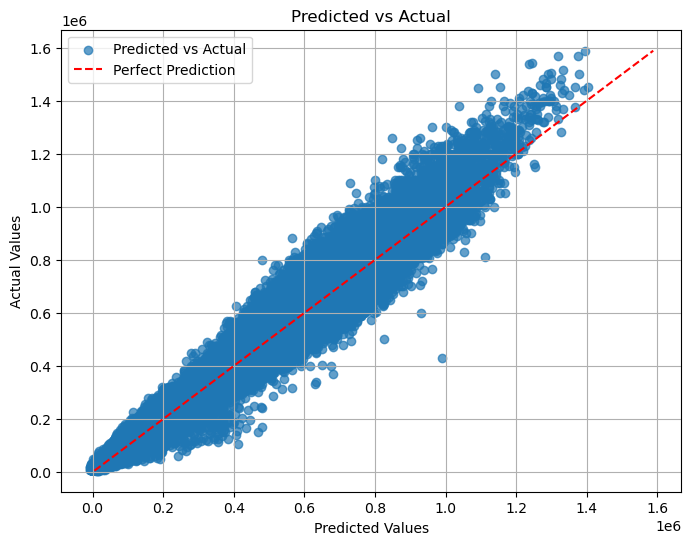

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

The Predicted vs Actual graph generally shows a linear relationship with a few outliers.

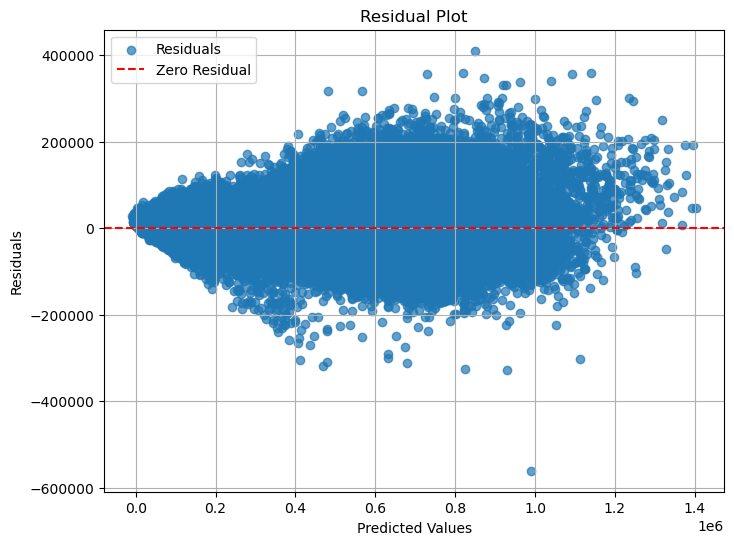

In [ ]:

y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

### 1.2.4 Feature Importance

Residuals generally spread evenly besides the zero line, without obvious systematic error.

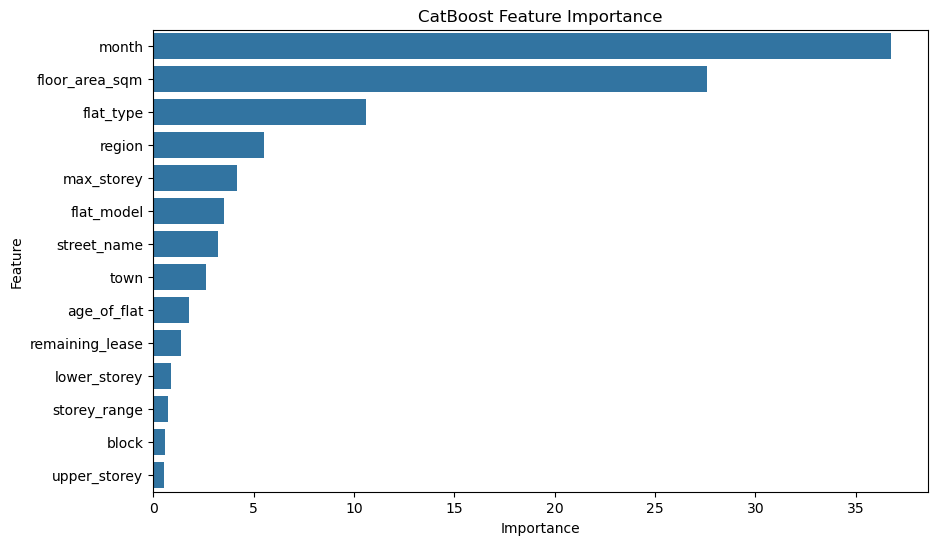

In [ ]:
# Extract feature importances from the CatBoost model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Features like "month" "floor_area_sqm" are of great importance, features like "upper_storey" and "block" are of smaller importance.

## 1.3 Refining

### 1.3.1 Reducing Features

To improve the performance our model and reduce noise, we first try reducing features that are less important. We would iterate from using all features to using top 8 most important features and monitor the changes in rmse and r2 scores.

In [ ]:
results = []

for num_features in range(14, 7, -1):  # From 14 features down to 8
    # Select top features
    selected_features = feature_importances['feature'][:num_features]
    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    # Update categorical features for reduced feature set
    categorical_features_reduced = X_train_reduced.select_dtypes(include=['object', 'category']).columns
    categorical_feature_indices_reduced = [X_train_reduced.columns.get_loc(col) for col in categorical_features_reduced]
    
    # Train the model
    model_reduced = CatBoostRegressor(cat_features=categorical_feature_indices_reduced, iterations=300, learning_rate=0.1, depth=6,verbose=0) 
    model_reduced.fit(X_train_reduced, y_train)
    
    # Make predictions
    y_train_pred = model_reduced.predict(X_train_reduced)
    y_test_pred = model_reduced.predict(X_test_reduced)
    
    # Evaluate the model
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results.append({
        'num_features': num_features,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'train_r2': train_r2
    })


results_df = pd.DataFrame(results)
print(results_df)


   num_features    train_rmse     test_rmse   test_r2  train_r2
0            14  29990.043516  30475.527245  0.969054  0.969906
1            13  30064.106580  30540.626252  0.968922  0.969757
2            12  30668.550938  31092.676900  0.967788  0.968529
3            11  30470.574456  30873.558483  0.968240  0.968934
4            10  32377.617555  32863.451727  0.964014  0.964923
5             9  32526.354600  33023.097959  0.963664  0.964600
6             8  33889.830138  34402.516098  0.960565  0.961570


The results shows that the model performs best when using all 14 features. We plotted RMSE vs number of features and it has a decreasing trend. The R2 score vs number of features shows an increasing trend. 

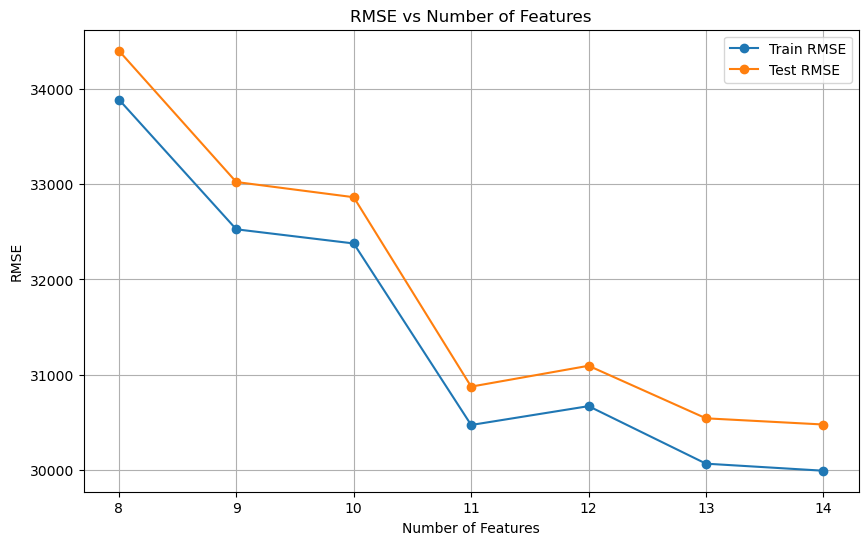

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['train_rmse'], label='Train RMSE', marker='o')
plt.plot(results_df['num_features'], results_df['test_rmse'], label='Test RMSE', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()


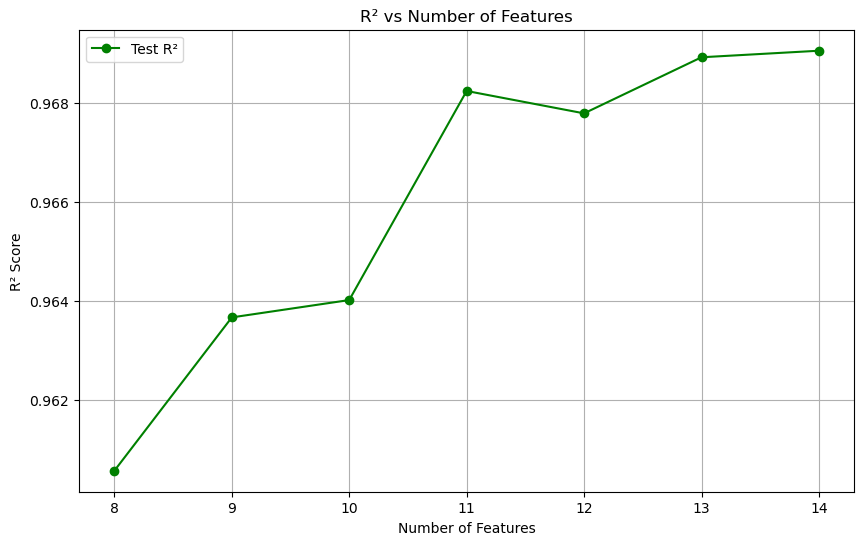

In [ ]:
# Plot Test R²
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['test_r2'], label='Test R²', marker='o', color='green')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()


### 1.3.2 Tuning Parameters

We then proceed to tuning parameters to see which combination of parameters for catboost would perform the best. Since Grid search is too time consuming, we choose randomized search.

reference: https://catboost.ai/en/docs/concepts/python-reference_catboost_randomized_search

In [ ]:

model = CatBoostRegressor(cat_features=categorical_feature_indices, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.03, 0.05, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [4, 5, 6, 7]
}

# Initialize RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)

# Fit RandomizedSearchCV
randomized_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", randomized_search.best_params_)
print("Best Score:", -randomized_search.best_score_)
    

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 10}
Best Score: 22984.805719727596


In [ ]:
model_adjusted_parameter = CatBoostRegressor(iterations=300,l2_leaf_reg= 5, learning_rate=0.05, depth=10, verbose=0)
model_adjusted_parameter.fit(X_train, y_train, cat_features=categorical_feature_indices)  

After obtaining the best combination of parameters, we check the rmse and r2 scores for both training and testing sets. They were all improved.

In [ ]:
# Make predictions on the train set
y_train_pred_adjusted_parameter = model_adjusted_parameter.predict(X_train)

# Calculate train performance metrics
train_rmse_pred_adjusted_parameter = root_mean_squared_error(y_train, y_train_pred_adjusted_parameter)
train_r2_pred_adjusted_parameter = r2_score(y_train, y_train_pred_adjusted_parameter)


print(f"Train RMSE with adjusted parameters: {train_rmse_pred_adjusted_parameter}")
print(f"Train R2 Score with adjusted parameters: {train_r2_pred_adjusted_parameter}")
print(f"Train RMSE before adjusting parameters: {train_rmse}")
print(f"Train R2 Score before adjusting parameters: {train_r2}")


Train RMSE with adjusted parameters: 27769.810864190677
Train R2 Score with adjusted parameters: 0.9741968516130738
Train RMSE before adjusting parameters: 33889.830138018646
Train R2 Score before adjusting parameters: 0.9615704197951928


In [ ]:
# Make predictions on the test set
y_test_pred_adjusted_parameter = model_adjusted_parameter.predict(X_test)

# Calculate test performance metrics
test_rmse_pred_adjusted_parameter = root_mean_squared_error(y_test, y_test_pred_adjusted_parameter)
test_r2_pred_adjusted_parameter = r2_score(y_test, y_test_pred_adjusted_parameter)

print(f"Test RMSE with adjusted parameters: {test_rmse_pred_adjusted_parameter}")
print(f"Test R2 Score with adjusted parameters: {test_r2_pred_adjusted_parameter}")
print(f"Test RMSE before adjusting parameters: {test_rmse}")
print(f"Test R2 Score before adjusting parameters: {test_r2}")


Test RMSE with adjusted parameters: 28274.288817012155
Test R2 Score with adjusted parameters: 0.9733629364394448
Test RMSE before adjusting parameters: 34402.516097739885
Test R2 Score before adjusting parameters: 0.9605648605752871


# 2. LightGBM

## 2.1 Modelling

reference source: https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

In [81]:
# Identify categorical columns by their data type
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert these columns to 'category' type
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

In [ ]:
import lightgbm as lgb

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "max_depth": -1,
    "learning_rate": 0.1,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    "num_iterations": 100,
    "verbose": 0,

}

# Prepare the dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Training the model with early stopping
model_2 = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predicting with the model
y_pred = model_2.predict(X_test, num_iteration=model_2.best_iteration)


## 2.2 Evaluation

### 2.2.1 RMSE and R2

In [83]:
# Make predictions on the train set
y_train_pred = model_2.predict(X_train)

# Calculate train performance metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2 Score: {train_r2}")

Train RMSE: 30213.679783743846
Train R2 Score: 0.9694554240390758


In [89]:
# Make predictions on the test set
y_pred = model_2.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 31151.516706353632
Test R2 Score: 0.9676658565989771


source: https://www.statology.org/what-is-a-good-rmse/

In [ ]:
# Assuming y_train is a numpy array or can be converted to one
y_train_np = np.array(y_train)
min_value = np.min(y_train_np)
max_value = np.max(y_train_np)
value_range = max_value - min_value
normalized_rmse = train_rmse / value_range

print("normalized_rmse:", normalized_rmse)


normalized_rmse: 0.019086342251259537


The relatively low normalized RMSE shows that the RMSE values are modest for both training and testing datasets, reflecting consistent model accuracy and reliability, as supported by high R² scores. The similar RMSE across datasets suggests that the model is well-balanced and free from overfitting. The performance of the LightGBM model is largely due to its effective management of categorical features with numerous unique values, which helps prevent underfitting and captures key data patterns.

### 2.2.2 Training and Validation Loss

We used the approach of validation to plot a graph of training loss and validation loss to check whether over fitting or underfitting occured.

source: https://www.baeldung.com/cs/training-validation-loss-deep-learning

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l1: 20018.4	train's l2: 9.12866e+08	valid's l1: 20458.2	valid's l2: 9.70417e+08


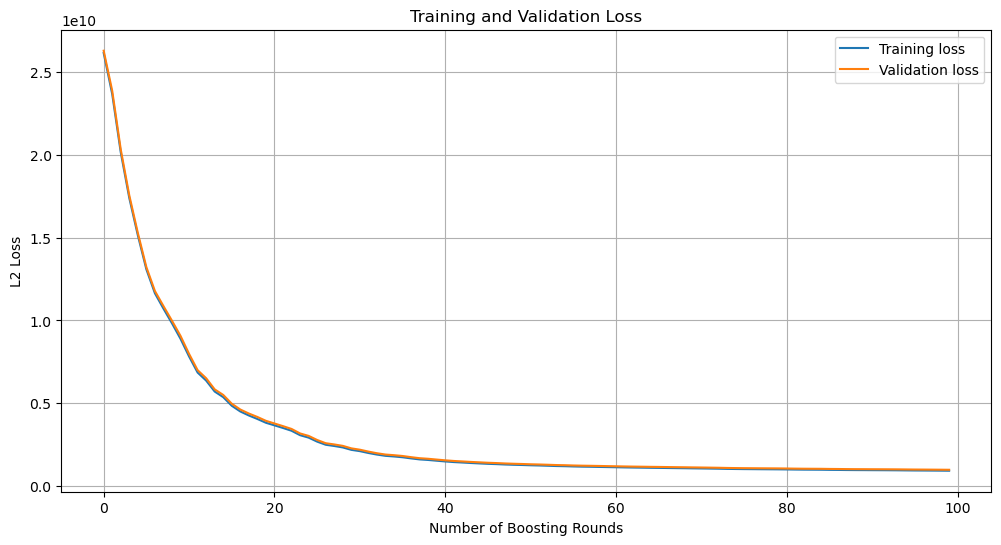

In [93]:
evals_result = {}

model_2 = lgb.train(
    params,
    train_data,
    num_boost_round=1000,  # Maximum number of boosting rounds
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.record_evaluation(evals_result), lgb.early_stopping(stopping_rounds=10)]
)

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(evals_result['train']['l2'], label='Training loss')
plt.plot(evals_result['valid']['l2'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('L2 Loss')
plt.legend()
plt.grid(True)
plt.show()


According to the graph, both validation and training loss are decreasing, which shows the model is good fitting.

### 2.2.3 Predicted vs Actual, Residual

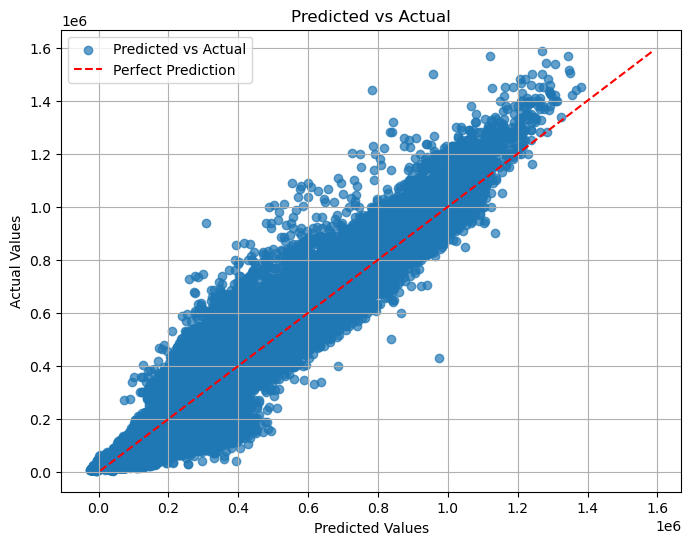

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

The Predicted vs Actual graph generally shows a linear relationship with a few outliers.

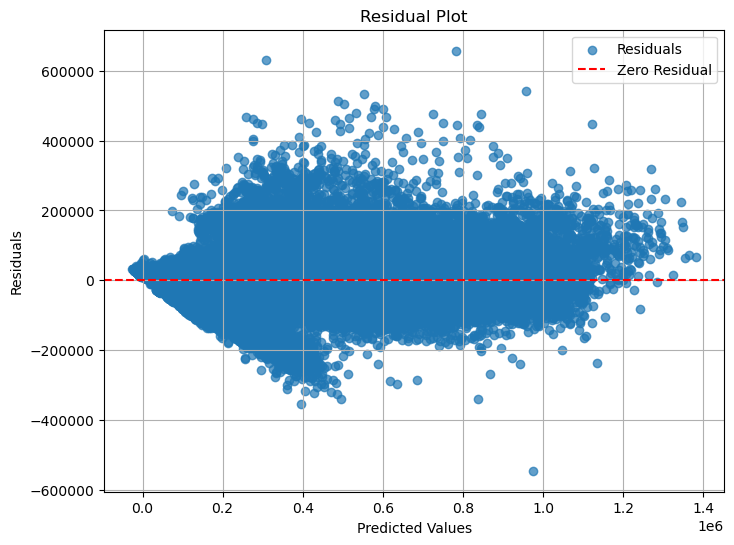

In [99]:
y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

Residuals generally spread evenly besides the zero line, without obvious systematic error.

### 2.2.4 K-fold validation

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

rmse_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Prepare the LightGBM datasets
    train_data_fold = lgb.Dataset(X_train_fold, label=y_train_fold)
    valid_data_fold = lgb.Dataset(X_test_fold, label=y_test_fold)

    # Train the model with early stopping
    model = lgb.train(
        params,
        train_data_fold,
        num_boost_round=1000,  # Max number of boosting rounds
        valid_sets=[valid_data_fold],
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=0)]  # Early stopping
    )

    # Predict on the validation fold
    y_pred = model.predict(X_test_fold, num_iteration=model.best_iteration)

    # Calculate MSE for the current fold
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
    rmse_scores.append(rmse)



In [106]:
# Output the results
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE across all folds:", np.mean(rmse_scores))

RMSE scores for each fold: [30740.966438605035, 31567.502817048204, 31085.9520107954, 31278.629210052986, 30479.63942623567]
Mean RMSE across all folds: 31030.53798054746


The RMSE scores from the five-fold validation is consistent. This suggests that the model is robust, not overly dependent on specific data characteristics within any single fold. Moreover, the close RMSE values across the folds demonstrate the model's strong generalization capability, indicating that it is likely to perform effectively on unseen data.

## 2.3 Refining

### 2.3.1 Tuning Parameters

We then proceed to tuning parameters to see which combination of parameters for catboost would perform the best. 

In [ ]:
clf = lgb.LGBMRegressor()

gridParams = {
    'learning_rate': [0.01, 0.05],  
    'num_leaves': [15, 31, 90, 100],  
    'max_depth': [-1, 5, 8],
    'min_data_in_leaf':[10,20,30],
    'no_iterations':[100,300,500]    
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=gridParams,
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    verbose=0,  
    random_state=42,  
    n_jobs=-1 
)

random_search.fit(X_train, y_train)


In [68]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'num_leaves': 100, 'no_iterations': 300, 'min_data_in_leaf': 30, 'max_depth': -1, 'learning_rate': 0.05}
Best Score: -29332.826153958584
[LightGBM] [Warning] Unknown parameter: no_iterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


After obtaining the best combination of parameters, we check the rmse and r2 scores for testing sets. They were all improved.

In [ ]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 100,
    "max_depth": -1,
    "learning_rate": 0.05,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    "num_iterations": 300,
    "verbose": 0,

}

# Prepare the dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Training the model with early stopping
model_adjusted = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


In [ ]:
# Make predictions on the test set
y_test_pred_adjusted_parameter = model_adjusted.predict(X_test)

# Calculate test performance metrics
test_rmse_pred_adjusted_parameter = root_mean_squared_error(y_test, y_test_pred_adjusted_parameter)
test_r2_pred_adjusted_parameter = r2_score(y_test, y_test_pred_adjusted_parameter)

print(f"Test RMSE with adjusted parameters: {test_rmse_pred_adjusted_parameter}")
print(f"Test R2 Score with adjusted parameters: {test_r2_pred_adjusted_parameter}")
print(f"Test RMSE before adjusting parameters: {test_rmse}")
print(f"Test R2 Score before adjusting parameters: {test_r2}")


Test RMSE with adjusted parameters: 23918.975798790078
Test R2 Score with adjusted parameters: 0.9809371370341358
Test RMSE before adjusting parameters: 31151.516706353632
Test R2 Score before adjusting parameters: 0.9676658565989771
